In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from keras.optimizers import Adam
from keras.models import load_model, Sequential
from keras.layers import Dense, Input
from keras import regularizers

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.utils import shuffle
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
%matplotlib  inline

C:\Users\EMO\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
df = pd.read_pickle("df_task_3")
scaler = StandardScaler()
X = scaler.fit_transform(df)
X = shuffle(X)
split = int(0.66*X.shape[0])
split_2 = split + (int((X.shape[0] - split)/2))
X_train = X[:split,:]
X_test = X[split:split_2,:]
X_dev = X[split_2:,:]
print(X_train.shape,X_test.shape,X_dev.shape)

(6743, 35) (1737, 35) (1737, 35)


The model for task 2 could be imoproved with clustering. The cluster and the probability estameate from each of 
the classifiers for every example can be feed into a neural network which will output the final probability estame. However here only the clustering analysis is done

In [3]:
def encoder_decoder(h_layer_nodes, mid_layer_nodes,r):
    model = Sequential()
    model.add(Dense(h_layer_nodes, input_dim=X_train.shape[1], activation='relu',kernel_regularizer=regularizers.l2(r)))
    model.add(Dense(mid_layer_nodes, activation='relu' ,kernel_regularizer=regularizers.l2(r)))
    model.add(Dense(h_layer_nodes, activation='relu',kernel_regularizer=regularizers.l2(r)))
    model.add(Dense(X_train.shape[1], kernel_regularizer=regularizers.l2(r)))
    return model


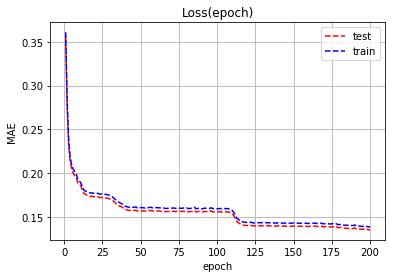

In [8]:
model = encoder_decoder(22, 11, 0.0001)
opt = Adam()
model.compile(loss='mean_absolute_error', optimizer=opt)
num_epochs = 201
last_ep = num_epochs
best_score = 1000000
counter = 0
test_scores = []
train_scores = []

for ep in range(1, num_epochs):
    
    model.fit(X_train, X_train, epochs=1, batch_size=32, shuffle=True,verbose=0)

    test_score = model.evaluate(X_dev, X_dev, verbose=0)
    train_score = model.evaluate(X_train, X_train, verbose=0)
    test_scores.append(test_score)
    train_scores.append(train_score)
    if test_score < best_score:
        best_score = test_score 
        counter = 0
    else:
        counter += 1
    if counter > 39:
        last_ep = (ep+1)
        break
fig, ax = plt.subplots()
ax.plot(range(1,last_ep), test_scores, "r--", label="valid")
ax.plot(range(1,last_ep), train_scores, "b--", label="train")
ax.set(xlabel='epoch', ylabel='MAE',
           title='Loss(epoch)')
    

ax.legend()
ax.grid()


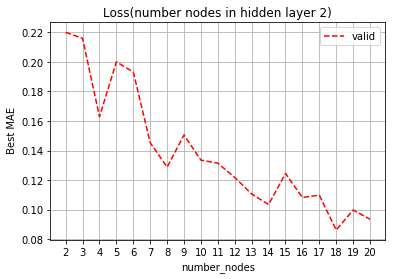

In [13]:
def search_num_hidden_nodes():
    num_epochs = 200
    test_scores = []
    max_nodes = 21
    for nodes in range(2,max_nodes):
        model = encoder_decoder(22, nodes, 0.0001)
        opt = Adam()
        model.compile(loss='mean_absolute_error', optimizer=opt)
        best_score = 100000
        for ep in range(1, num_epochs+1):
            model.fit(X_train, X_train, epochs=1, batch_size=32, shuffle=True,verbose=0)

            test_score = model.evaluate(X_dev, X_dev, verbose=0)

            if test_score < best_score:
                best_score = test_score 
        test_scores.append(best_score)
    fig, ax = plt.subplots()
    ax.plot(range(2,max_nodes), test_scores, "r--", label="valid")
    ax.set(xlabel='number_nodes', ylabel=' Best MAE',
           title='Loss(number nodes in hidden layer 2)')
    

    ax.legend()
    ax.grid()
    plt.xticks(range(2,max_nodes))

search_num_hidden_nodes()

Best score: 0.1307630651020839   Best epoch: 404


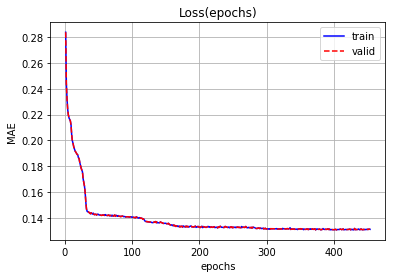

In [14]:
def train_neural_network():
    model = encoder_decoder(22, 8, 0.0001)
    opt = Adam()
    model.compile(loss='mean_absolute_error', optimizer=opt)
    best_score = 100000
    train_scores = []
    test_scores = []
    num_epochs = 1001
    last_ep = num_epochs 
    counter = 0
    for ep in range(1, num_epochs):
        model.fit(X_train, X_train, epochs=1, batch_size=32, shuffle=True,verbose=0)
        
        test_score = model.evaluate(X_dev, X_dev, verbose=0)
        train_score = model.evaluate(X_train, X_train, verbose=0)
                
        train_scores.append(test_score)
        test_scores.append(test_score)
        
        if test_score < best_score:
            best_score = test_score 
            model.save_weights("weights_encoder_decoder.h5")
            best_ep = ep
            counter = 0
        else:
            counter += 1
        if counter == 50:
            last_ep = (1+ep)
            break
    print("Best score:",best_score,"  Best epoch:" ,best_ep)
    fig, ax = plt.subplots()
    ax.plot(range(1,last_ep), train_scores, "b-", label="train")
    ax.plot(range(1,last_ep), test_scores, "r--", label="valid")
    ax.set(xlabel='epochs', ylabel='MAE',
           title='Loss(epochs)')

    ax.legend()
    ax.grid()
train_neural_network()

In [15]:
def load_best_nn_model(weights_name):
    model = encoder_decoder(22, 8, 0.0001)
    model.load_weights(weights_name)
    opt = Adam()
    model.compile(loss='mean_absolute_error', optimizer=opt)
    encoder = Sequential()
    encoder.add(model.layers[0])
    encoder.add(model.layers[1])
    return encoder
encoder = load_best_nn_model("weights_encoder_decoder.h5")

In [20]:
model = encoder_decoder(22, 8, 0.0001)
model.load_weights("weights_encoder_decoder.h5")
opt = Adam()
model.compile(loss='mean_absolute_error', optimizer=opt)
print(model.evaluate(X_test, X_test, verbose=0))
idxs = [int(x) for x in sample]
sample_X = X_test[idxs,:]
print(model.evaluate(sample_X, sample_X, verbose=0))

0.14503770596554175
0.0817476436495781


In [21]:
new_X = encoder.predict(X) 

Text(0.5,1,'Elbow method')

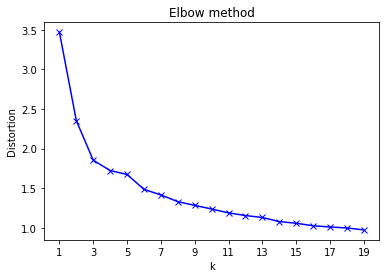

In [22]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(new_X)
    kmeanModel.fit(new_X)
    distortions.append(sum(np.min(cdist(new_X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / new_X.shape[0])
plt.plot(K, distortions, 'bx-')
plt.xticks(range(1,20,2))
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow method')

In [23]:
model = Sequential()
model.add(Dense(22, input_dim=X_train.shape[1], activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(7, activation='relu' ,kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(22, activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(X_train.shape[1], kernel_regularizer=regularizers.l2(0.0001)))
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_absolute_error', optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (None, 22)                792       
_________________________________________________________________
dense_178 (Dense)            (None, 7)                 161       
_________________________________________________________________
dense_179 (Dense)            (None, 22)                176       
_________________________________________________________________
dense_180 (Dense)            (None, 35)                805       
Total params: 1,934
Trainable params: 1,934
Non-trainable params: 0
_________________________________________________________________
